## Library installation

In [ ]:
#Libraries to import

import pandas as pandas
import yfinance as yfinance
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import numpy as np
import time

## Data Initialisation (Cleaning)

In [10]:
#Scrapigng the data for stock prices

import yfinance as yf
import pandas as pd
tickers = ["^GSPC", "AAPL", "NVDA", "MSFT", "NFLX"]
start_date = "2020-01-01"
end_date = "2025-01-01"

data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/dataframe.csv')
stocks = pd.read_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/dataframe.csv')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [11]:
#Cleaning the data 
stocks.drop(["Close", "Close.1", "Close.2", "Close.3", "Close.4"], axis=1, inplace=True)
stocks.drop(["High", "High.1", "High.2", "High.3", "High.4"], axis=1, inplace=True)
stocks.drop(["Volume", "Volume.1", "Volume.2", "Volume.3", "Volume.4"], axis=1, inplace=True)
stocks.drop(["Low", "Low.1", "Low.2", "Low.3", "Low.4"], axis=1, inplace=True)

In [12]:
stocks.head()

,Price,Open,Open.1,Open.2,Open.3,Open.4
0,Ticker,AAPL,MSFT,NFLX,NVDA,^GSPC
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,71.72101896406637,151.56681935407136,326.1000061035156,5.943831396827032,3244.669921875
3,2020-01-03,71.94133580542943,151.12776374356721,326.7799987792969,5.852962643555382,3226.360107421875
4,2020-01-06,71.12785848416316,149.9440697335836,323.1199951171875,5.783753612157114,3217.550048828125


In [13]:
#Complete remaining data cleaning in Excel and then reimport back:
# Save the DataFrame to an Excel file
# Save the DataFrame to a CSV file
stocks.to_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/dataframe.csv', index=False)


In [14]:
#Decided to change the variable name to dataframe after edits made in Excel for clarity
#Treated 'stocks' variable still as raw and uncleaned data
df = pd.read_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/dataframe_cleaned.csv')

In [15]:
df = df.round(2)
df.head()

,Date,SPX,AAPL,MSFT,NFLX,NVDA
0,02/01/2020,3244.67,71.72,151.57,326.10,5.94
1,03/01/2020,3226.36,71.94,151.13,326.78,5.85
2,06/01/2020,3217.55,71.13,149.94,323.12,5.78
3,07/01/2020,3241.86,72.59,152.08,336.47,5.93
4,08/01/2020,3238.59,71.94,151.71,331.49,5.97


In [16]:
import time
if isinstance(df.index, pd.DatetimeIndex):
    print("Time Series has been set")
else:
    print("Time Series has not been set yet")
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    time.sleep(3)
    print("It has been done now!")

    

Time Series has not been set yet
It has been done now!


In [17]:
df.describe()

,SPX,AAPL,MSFT,NFLX,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,4258.915016,152.022560,288.461645,470.336359,38.450254
std,767.478057,42.016641,81.924408,155.601437,38.295102
min,2290.710000,55.350000,131.140000,163.960000,4.980000
25%,3817.265000,126.390000,228.950000,359.082500,13.605000
50%,4206.095000,150.580000,276.815000,480.740000,21.175000
75%,4602.850000,176.640000,333.370000,563.802500,45.752500
max,6089.030000,257.910000,464.300000,933.350000,149.340000


In [18]:
#Segregating dataset into the training and testing model. We have decided to go for a (70:30 split)
#df = training set
#df_test = testing set
size = int(len(df)*0.7)
df, df_test = df.iloc[:size], df.iloc[size:]

In [19]:
df.describe(), df_test.describe()

(               SPX        AAPL        MSFT        NFLX        NVDA
 count   880.000000  880.000000  880.000000  880.000000  880.000000
 mean   3895.282091  132.100511  244.091886  418.642432   17.546500
 std     520.017755   30.856592   47.882779  128.836338    7.673015
 min    2290.710000   55.350000  131.140000  163.960000    4.980000
 25%    3563.082500  117.342500  207.012500  325.840000   12.897500
 50%    3973.415000  139.440000  244.490000  425.000000   15.945000
 75%    4278.480000  153.172500  280.787500  516.570000   22.245000
 max    4804.510000  189.980000  346.580000  692.350000   43.480000,
                SPX        AAPL        MSFT        NFLX        NVDA
 count   378.000000  378.000000  378.000000  378.000000  378.000000
 mean   5105.467857  198.401931  391.756323  590.682011   87.115079
 std     553.378229   24.147368   41.699324  145.832482   36.849495
 min    4139.390000  164.570000  307.440000  351.000000   40.430000
 25%    4554.500000  178.150000  363.555000  45

## Visualising data and preparing for training phase

Text(0.5, 1.0, 'Stock Prices')

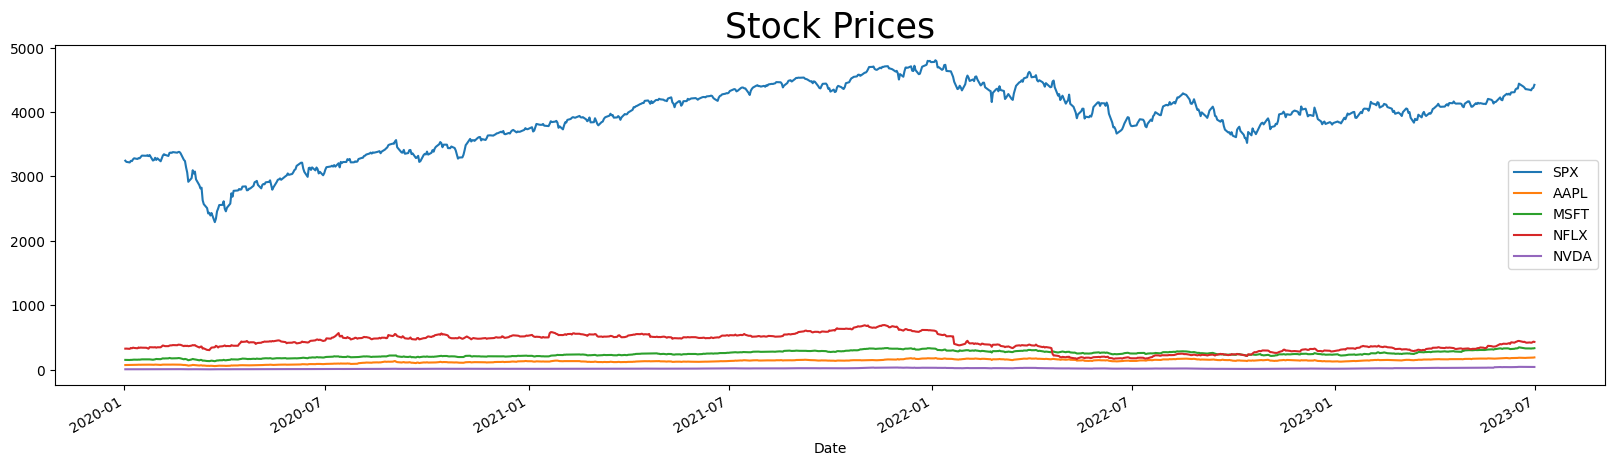

In [20]:
#We find that our S&P 500 prices is shown to be significantly higher compared to the other stocks, 
#so we should normalise prices, so they are in base units.
import matplotlib.pyplot as plt
df.plot(figsize=(20,5))
plt.title("Stock Prices", size = 25)

In [21]:
#We should normalise and log stock prices for both the training and testing sets, so that we are consistent throughout
df_norm = df/df.iloc[0]*100 #Create a new variable incase we want to visualise/test/forecast with the original data
df_norm_test = df_test/df.iloc[0]*100

import numpy as np   
df_log = np.log(df / df.shift(1))
df_log_test = np.log(df_test / df_test.shift(1))

Text(0.5, 1.0, 'Normalised Stock Prices')

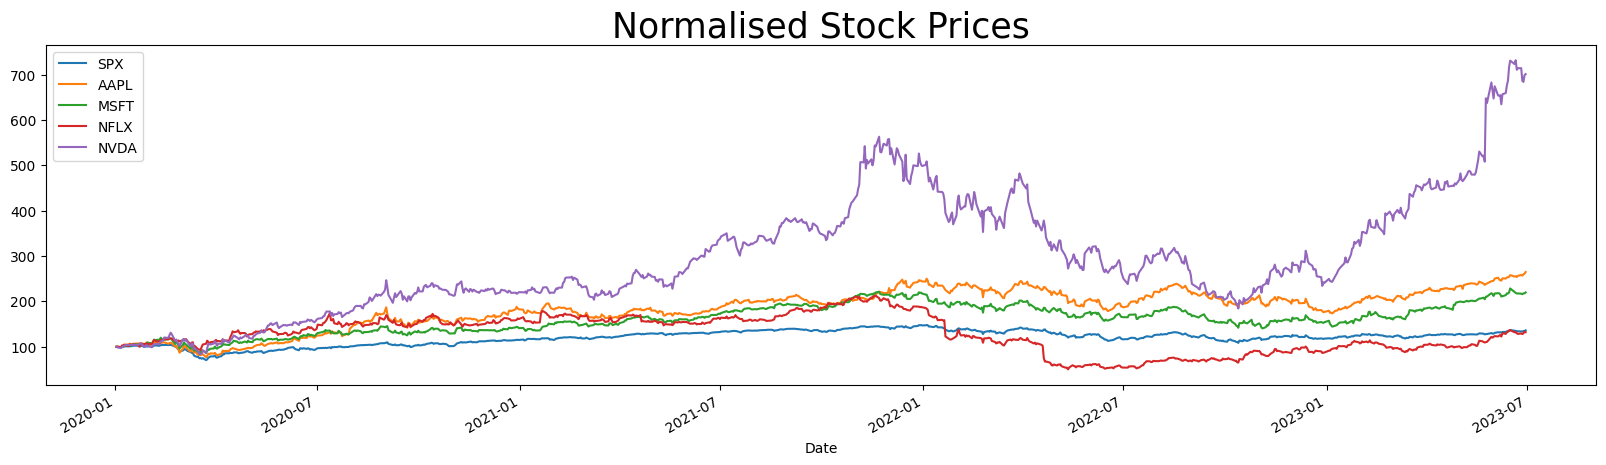

In [22]:
df_norm.plot(figsize=(20,5))
plt.title("Normalised Stock Prices", size = 25) 

Text(0.5, 1.0, 'Normalised Stock Prices')

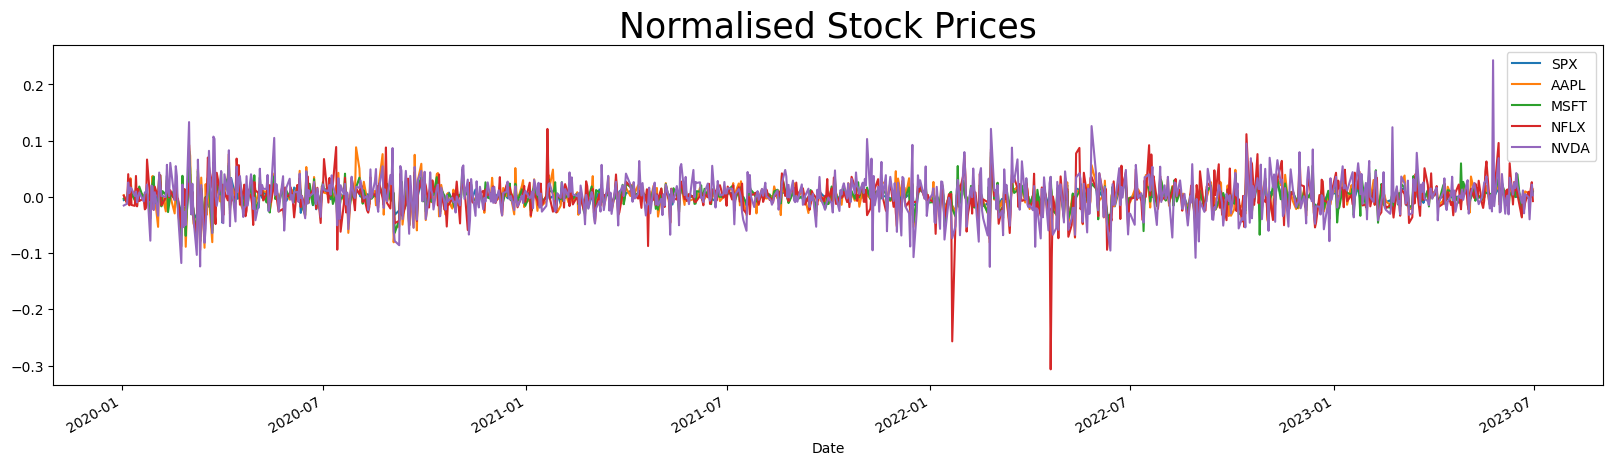

In [23]:
df_log.plot(figsize=(20,5))
plt.title("Normalised Stock Prices", size = 25) 

In [24]:
df.head(), df_log.head() 
#Since we have now log transformed our data, we need to be 
#careful when doing making interpretations

(                SPX   AAPL    MSFT    NFLX  NVDA
 Date                                            
 2020-01-02  3244.67  71.72  151.57  326.10  5.94
 2020-01-03  3226.36  71.94  151.13  326.78  5.85
 2020-01-06  3217.55  71.13  149.94  323.12  5.78
 2020-01-07  3241.86  72.59  152.08  336.47  5.93
 2020-01-08  3238.59  71.94  151.71  331.49  5.97,
                  SPX      AAPL      MSFT      NFLX      NVDA
 Date                                                        
 2020-01-02       NaN       NaN       NaN       NaN       NaN
 2020-01-03 -0.005659  0.003063 -0.002907  0.002083 -0.015267
 2020-01-06 -0.002734 -0.011323 -0.007905 -0.011263 -0.012038
 2020-01-07  0.007527  0.020318  0.014171  0.040485  0.025621
 2020-01-08 -0.001009 -0.008995 -0.002436 -0.014911  0.006723)

### Testing for Stationarity

In [25]:
#st_test = ADF (Stationarity) Test
import statsmodels.tsa.stattools as sts
SPX_st_test = sts.adfuller(df_log.SPX[1:])
print(SPX_st_test)
AAPL_st_test = sts.adfuller(df_log.AAPL[1:])
print(AAPL_st_test)
MSFT_st_test = sts.adfuller(df_log.MSFT[1:])
print(MSFT_st_test)
NFLX_st_test = sts.adfuller(df_log.NFLX[1:])
print(NFLX_st_test)
NVDA_st_test = sts.adfuller(df_log.NVDA[1:])
print(NVDA_st_test)

(np.float64(-27.879436732463013), 0.0, 0, 878, {'1%': np.float64(-3.437819842246547), '5%': np.float64(-2.8648374649929753), '10%': np.float64(-2.5685258078777093)}, np.float64(-5071.500653506166))
(np.float64(-23.047610659063313), 0.0, 1, 877, {'1%': np.float64(-3.4378283848659277), '5%': np.float64(-2.864841231335243), '10%': np.float64(-2.5685278140988053)}, np.float64(-4101.693868657694))
(np.float64(-23.466205539702464), 0.0, 1, 877, {'1%': np.float64(-3.4378283848659277), '5%': np.float64(-2.864841231335243), '10%': np.float64(-2.5685278140988053)}, np.float64(-4305.52312504884))
(np.float64(-27.529430212877582), 0.0, 0, 878, {'1%': np.float64(-3.437819842246547), '5%': np.float64(-2.8648374649929753), '10%': np.float64(-2.5685258078777093)}, np.float64(-3592.3494559492665))
(np.float64(-31.750317823653486), 0.0, 0, 878, {'1%': np.float64(-3.437819842246547), '5%': np.float64(-2.8648374649929753), '10%': np.float64(-2.5685258078777093)}, np.float64(-3297.165354484974))


In [26]:
#Further justifies why we should use logarithmically transformed prices as opposed to original prices
from statsmodels.tsa.stattools import adfuller

# Drop rows with missing values
df_log_clean = df_log.dropna()

# Iterate over each column in the cleaned DataFrame
for column in df_log_clean.columns:
    result = adfuller(df_log_clean[column])
    print(f'p-value for {column}: {result[1]:5f}')

p-value for SPX: 0.000000
p-value for AAPL: 0.000000
p-value for MSFT: 0.000000
p-value for NFLX: 0.000000
p-value for NVDA: 0.000000


In [27]:
#With no transformation, we see that prices are non-stationary, meaning we would have required 
#differencing to an order of integration N I(N)
from statsmodels.tsa.stattools import adfuller

# Iterate over each column in the cleaned DataFrame
for column in df.columns:
    result = adfuller(df[column])
    print(f'p-value for {column}: {result[1]:5f}')

p-value for SPX: 0.544914
p-value for AAPL: 0.643005
p-value for MSFT: 0.620584
p-value for NFLX: 0.577487
p-value for NVDA: 0.980913


## ACF and PACF tests for AR and MA lags

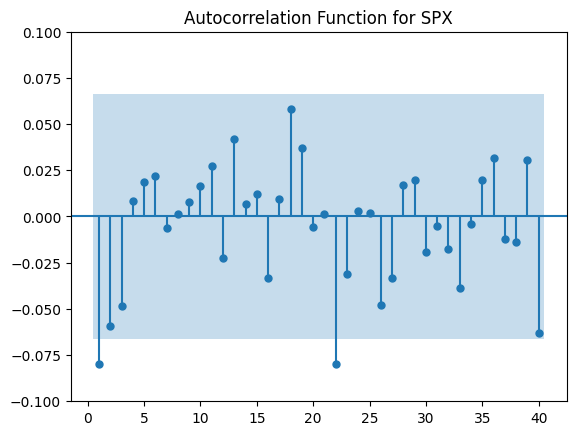

In [49]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_pacf(df_log.AAPL[1:], lags=40, zero=False)
plt.title('Autocorrelation Function for SPX')
plt.ylim(-0.1,0.1)
plt.show()
